In [ ]:
!pip install lightning-bolts --quiet

In [ ]:
!rm -rf S18
!git clone https://github.com/mHemaAP/S18.git

Cloning into 'S18'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 44 (delta 9), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (44/44), 1.63 MiB | 12.67 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
%cd S18/Part2
%ls

/kaggle/working/S18/Part2
S18_VAE_CIFAR10_train.ipynb  data_module/  vae.py
S18_VAE_MNIST_train.ipynb    utils.py


In [ ]:
import random
import numpy as np
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, figure

from torchvision.utils import make_grid

from vae import VAE
from data_module.mnist import MNIST_DataModule

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed a

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
mnist_data_module = MNIST_DataModule()

In [ ]:
pl.seed_everything(56)
vae_model = VAE()
trainer = pl.Trainer(gpus=1, max_epochs=11)
trainer.fit(vae_model, mnist_data_module)

100%|██████████| 9912422/9912422 [00:00<00:00, 110066399.40it/s]


Extracting data/MNIST2RGB/raw/train-images-idx3-ubyte.gz to data/MNIST2RGB/raw



100%|██████████| 28881/28881 [00:00<00:00, 94489620.77it/s]


Extracting data/MNIST2RGB/raw/train-labels-idx1-ubyte.gz to data/MNIST2RGB/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37629312.78it/s]


Extracting data/MNIST2RGB/raw/t10k-images-idx3-ubyte.gz to data/MNIST2RGB/raw



100%|██████████| 4542/4542 [00:00<00:00, 5544391.38it/s]


Extracting data/MNIST2RGB/raw/t10k-labels-idx1-ubyte.gz to data/MNIST2RGB/raw



Training: 0it [00:00, ?it/s]

Training loss at end of epoch 0 = 3048.577880859375
Training loss at end of epoch 1 = 2330.43359375
Training loss at end of epoch 2 = 1578.750732421875
Training loss at end of epoch 3 = 747.517333984375
Training loss at end of epoch 4 = -15.032268524169922
Training loss at end of epoch 5 = -570.3949584960938
Training loss at end of epoch 6 = -909.1444702148438
Training loss at end of epoch 7 = -1140.8636474609375
Training loss at end of epoch 8 = -1315.765869140625
Training loss at end of epoch 9 = -1440.0106201171875
Training loss at end of epoch 10 = -1628.3551025390625


In [ ]:
test_data = mnist_data_module.test_dataloader()
# Get the first batch (a batch of images and labels) by break
for batch in test_data:
    images, label_ohe, label_ohe_random= batch
    break

In [ ]:
# Select one image and its corresponding label
index = random.randint(0, 63)
image = images[index]
label_ohe_correct= label_ohe[index]
label_ohe_incorrect = label_ohe_random[index]

label_correct = np.argmax(label_ohe_correct)
label_incorrect = np.argmax(label_ohe_incorrect)

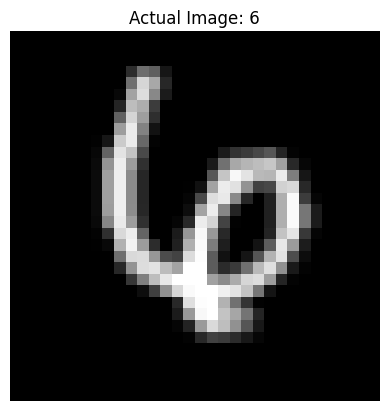

In [ ]:
# Plot the itest image
plt.imshow(image[0], cmap='gray')
plt.axis('off')
plt.title(f"Actual Image: {label_correct}")
plt.show()

In [ ]:
image = image.unsqueeze(0)

with torch.no_grad():

    # Pass this image through VAE encoder and plot the decoder output
    # Move the entire model to GPU
    vae_model = vae_model.to('cuda')
    encoded_image = vae_model.encoder(image.to('cuda'))
    # Get OHE for label features
    combined_features = torch.cat((encoded_image, label_ohe_correct.unsqueeze(0).to('cuda')), dim=1)


    mu, log_var = vae_model.fc_mu(combined_features), vae_model.fc_var(combined_features)

    # sample z from q
    std = torch.exp(log_var / 2)
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()

    # decoded
    decoded_image = vae_model.decoder(z).to('cpu').detach().numpy()

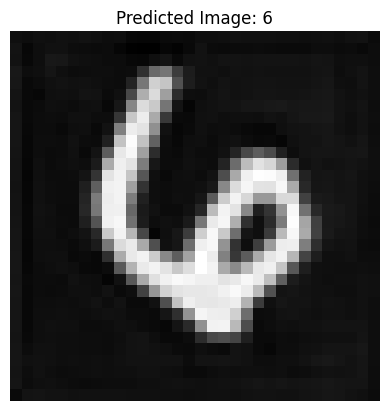

In [ ]:
# Plot the generated image with actual label
#plt.figure(figsize=(2, 2))
plt.imshow(decoded_image[0,0], cmap='gray')
plt.axis('off')
plt.title(f"Predicted Image: {label_correct}")
plt.show()

In [ ]:
decoded_images = []
decoded_images_plot = []
with torch.no_grad():

    for i in range(25):
        if len(decoded_images) == 0:
            image = image
        else:
            image = decoded_images[-1]
        # Now pass this image through VAE encoder and plot the decoder output
        encoded_image = vae_model.encoder(image.to('cuda'))
        # Get OHE for label features
        combined_features = torch.cat((encoded_image, label_ohe_incorrect.unsqueeze(0).to('cuda')), dim=1)

        mu, log_var = vae_model.fc_mu(combined_features), vae_model.fc_var(combined_features)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        decoded_image = vae_model.decoder(z)
        decoded_images.append(decoded_image)
        decoded_image = decoded_image.to('cpu').detach().numpy()
        decoded_images_plot.append(decoded_image[0, 0])

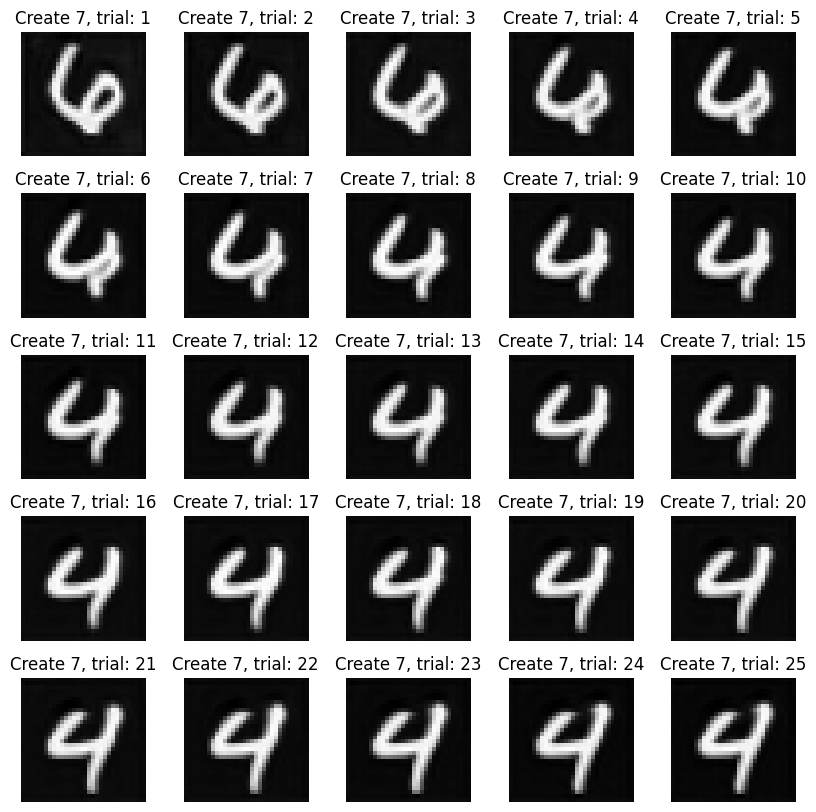

In [ ]:
# Plot the 25 images

# Create a 5x5 grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Flatten the axes array so that we can iterate over it easily
axes = axes.flatten()

# Iterate through the images and plot them in the subplots
for i, ax in enumerate(axes):
    # Replace 'gray' with a colormap
    ax.imshow(decoded_images_plot[i], cmap='gray')
    ax.set_title(f"Create {label_incorrect}, trial: {i+1}")
    # Turn off axis labels and ticks
    ax.axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Display the plot
plt.show()